In [1]:
import numpy as np
import pandas as pd
from os import path
from random import choice, shuffle

from ga4stpg.graph import Graph, ReaderORLibrary
from ga4stpg.graph.steiner import (prunning_mst, shortest_path,
                            shortest_path_origin_prim,
                            prunning_kruskal_mst,
                            shortest_path_with_origin)

from ga4stpg.graph.util import (is_steiner_tree, 
                                has_cycle,
                                gg_total_weight)
from ga4stpg.graph.algorithms import kruskal, prim

In [2]:
# input
dataset_file = 'steinc5.txt'

# output
csv_output = 'resultado.csv'
graphs_output = 'grafos.pickle'

In [3]:
file = path.join('..', 'datasets','ORLibrary', dataset_file)

assert path.exists(file)

reader = ReaderORLibrary()

stpg = reader.parser(file)

In [4]:
from ga4stpg.tree.pxcrossover import PXTree
from ga4stpg.tree.evaluation import EvaluateTreeGraph

In [5]:
crossover = PXTree(stpg)
evaluator = EvaluateTreeGraph(stpg)

In [6]:
vertices = list(stpg.graph.vertices)

shuffle(vertices)

v = vertices.pop()

aa, aa_cost = shortest_path_with_origin(stpg.graph, v, stpg.terminals)

r, test = is_steiner_tree(aa, stpg)

r, test

(True,
 {'has_cycle': False,
  'all_terminals_in': True,
  'all_leaves_are_terminals': True,
  'all_edges_are_reliable': True,
  'graph_is_connected': True})

In [7]:
%%time

data = list()
print(stpg.nro_nodes)

for _ in range(200):
    v = vertices.pop()
    aa, aa_cost = prunning_mst(stpg.graph, v, stpg.terminals)
    is_aa_st, _ = is_steiner_tree(aa, stpg)
    
    u = vertices.pop()
    bb, bb_cost = prunning_mst(stpg.graph, u, stpg.terminals)
    is_bb_st, _ = is_steiner_tree(bb, stpg)
    
    child = crossover(aa, bb)
    cc_cost, _ = evaluator(child)
    is_cc_st, _ = is_steiner_tree(child, stpg)
    
    data.append([v, u, is_aa_st, is_bb_st, is_cc_st, aa_cost, bb_cost, cc_cost])

500
Wall time: 9.83 s


In [8]:
col = [
    'start_a', 
    'start_b', 
    'is_aa_st', 
    'is_bb_st', 
    'is_cc_st' ,
    'a_cost', 
    'b_cost', 
    'c_cost'
    ]

In [9]:
%%time 

frame = pd.DataFrame(data, columns=col)

Wall time: 3 ms


In [10]:
frame['less_both'] = (frame['c_cost'] < frame['a_cost']) & (frame['c_cost'] < frame['b_cost'])

In [11]:
frame['less_equal_both'] = (frame['c_cost'] <= frame['a_cost']) & (frame['c_cost'] <= frame['b_cost'])

In [12]:
frame['less_equal_a'] = (frame['c_cost'] <= frame['a_cost'])

In [13]:
frame['less_equal_b'] = (frame['c_cost'] <= frame['b_cost'])

In [14]:
frame.head()

,start_a,start_b,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b
0,75,225,True,True,True,1640,1630,1630,False,True,True,True
1,387,90,True,True,True,1633,1638,1633,False,True,True,True
2,471,356,True,True,True,1630,1640,1630,False,True,True,True
3,331,262,True,True,True,1630,1647,1630,False,True,True,True
4,466,418,True,True,True,1634,1640,1634,False,True,True,True


In [15]:

# all solutions were classified as steiner tree

# np.all(frame['is_aa_st'])
# np.all(frame['is_bb_st'])
# np.all(frame['is_cc_st'])

frame[['is_aa_st',	'is_bb_st',	'is_cc_st']].describe()

,is_aa_st,is_bb_st,is_cc_st
count,200,200,200
unique,1,1,1
top,True,True,True
freq,200,200,200


In [16]:
np.all(frame['less_equal_both'])

True

In [17]:
frame[['a_cost', 'b_cost','c_cost']].min()

a_cost    1630
b_cost    1630
c_cost    1628
dtype: int64

In [18]:
frame[['a_cost', 'b_cost','c_cost']].max()

a_cost    1640
b_cost    1655
c_cost    1640
dtype: int64

In [19]:
frame[['less_both', 'less_equal_a', 'less_equal_b', 'less_equal_both']].describe()

,less_both,less_equal_a,less_equal_b,less_equal_both
count,200,200,200,200
unique,2,1,1,1
top,False,True,True,True
freq,159,200,200,200


In [20]:
frame['diff_from_a'] = frame['a_cost'] - frame['c_cost']
frame['diff_from_b'] = frame['b_cost'] - frame['c_cost']

In [21]:
df_stats = frame[['a_cost',	'b_cost', 'c_cost', 'diff_from_a', 'diff_from_b']].describe()

df_stats

,a_cost,b_cost,c_cost,diff_from_a,diff_from_b
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1636.395000,1636.480000,1634.225000,2.170000,2.255000
std,3.126958,3.713293,3.290671,2.910922,3.176543
min,1630.000000,1630.000000,1628.000000,0.000000,0.000000
25%,1634.000000,1634.000000,1633.000000,0.000000,0.000000
50%,1637.000000,1637.000000,1634.000000,1.000000,1.000000
75%,1640.000000,1640.000000,1636.000000,3.000000,4.000000
max,1640.000000,1655.000000,1640.000000,10.000000,20.000000


In [22]:
# df_stats.to_clipboard()

<AxesSubplot:>

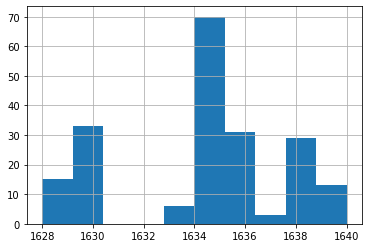

In [23]:
frame['c_cost'].hist()

<AxesSubplot:>

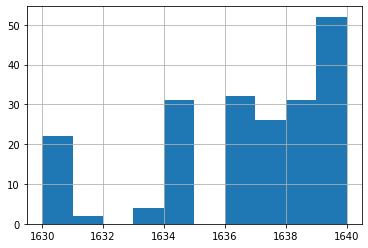

In [24]:
frame['a_cost'].hist()

<AxesSubplot:>

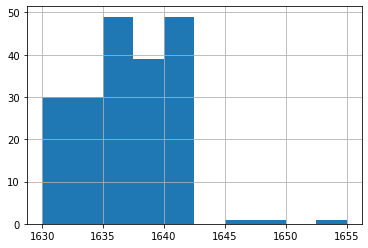

In [25]:
frame['b_cost'].hist()

In [26]:
frame.shape

(200, 14)

In [27]:
frame.iloc[0:10]

,start_a,start_b,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b,diff_from_a,diff_from_b
0,75,225,True,True,True,1640,1630,1630,False,True,True,True,10,0
1,387,90,True,True,True,1633,1638,1633,False,True,True,True,0,5
2,471,356,True,True,True,1630,1640,1630,False,True,True,True,0,10
3,331,262,True,True,True,1630,1647,1630,False,True,True,True,0,17
4,466,418,True,True,True,1634,1640,1634,False,True,True,True,0,6
5,103,482,True,True,True,1634,1636,1634,False,True,True,True,0,2
6,22,11,True,True,True,1640,1638,1638,False,True,True,True,2,0
7,157,190,True,True,True,1634,1636,1634,False,True,True,True,0,2
8,105,107,True,True,True,1634,1640,1634,False,True,True,True,0,6
9,396,181,True,True,True,1630,1630,1630,False,True,True,True,0,0


In [28]:
frame.iloc[10:20]

,start_a,start_b,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b,diff_from_a,diff_from_b
10,492,258,True,True,True,1640,1640,1640,False,True,True,True,0,0
11,259,398,True,True,True,1631,1640,1630,True,True,True,True,1,10
12,163,423,True,True,True,1638,1630,1628,True,True,True,True,10,2
13,147,362,True,True,True,1640,1636,1636,False,True,True,True,4,0
14,142,125,True,True,True,1640,1640,1640,False,True,True,True,0,0
15,271,317,True,True,True,1634,1633,1633,False,True,True,True,1,0
16,255,424,True,True,True,1630,1636,1630,False,True,True,True,0,6
17,479,178,True,True,True,1640,1637,1637,False,True,True,True,3,0
18,438,230,True,True,True,1640,1638,1638,False,True,True,True,2,0
19,26,281,True,True,True,1638,1640,1638,False,True,True,True,0,2


In [29]:
frame.iloc[20:30]

,start_a,start_b,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b,diff_from_a,diff_from_b
20,192,324,True,True,True,1636,1634,1634,False,True,True,True,2,0
21,480,45,True,True,True,1637,1639,1634,True,True,True,True,3,5
22,314,151,True,True,True,1637,1637,1637,False,True,True,True,0,0
23,135,494,True,True,True,1634,1640,1634,False,True,True,True,0,6
24,434,410,True,True,True,1631,1630,1630,False,True,True,True,1,0
25,100,205,True,True,True,1638,1640,1638,False,True,True,True,0,2
26,462,179,True,True,True,1638,1630,1628,True,True,True,True,10,2
27,62,412,True,True,True,1630,1630,1630,False,True,True,True,0,0
28,414,61,True,True,True,1638,1630,1628,True,True,True,True,10,2
29,343,467,True,True,True,1640,1640,1640,False,True,True,True,0,0


In [30]:
frame.iloc[30:40]

,start_a,start_b,is_aa_st,is_bb_st,is_cc_st,a_cost,b_cost,c_cost,less_both,less_equal_both,less_equal_a,less_equal_b,diff_from_a,diff_from_b
30,31,87,True,True,True,1636,1640,1636,False,True,True,True,0,4
31,382,8,True,True,True,1636,1634,1634,False,True,True,True,2,0
32,341,417,True,True,True,1630,1630,1630,False,True,True,True,0,0
33,121,65,True,True,True,1640,1640,1640,False,True,True,True,0,0
34,10,293,True,True,True,1638,1640,1638,False,True,True,True,0,2
35,191,169,True,True,True,1634,1634,1634,False,True,True,True,0,0
36,407,376,True,True,True,1638,1636,1634,True,True,True,True,4,2
37,79,159,True,True,True,1637,1638,1635,True,True,True,True,2,3
38,70,247,True,True,True,1636,1636,1636,False,True,True,True,0,0
39,174,270,True,True,True,1634,1638,1634,False,True,True,True,0,4
